In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [2]:
# Generate data paths with labels
data_dir = 'Dataset_BUSI_with_GT'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

,filepaths,labels
0,Dataset_BUSI_with_GT\benign\benign (1).png,benign
1,Dataset_BUSI_with_GT\benign\benign (1)_mask.png,benign
2,Dataset_BUSI_with_GT\benign\benign (10).png,benign
3,Dataset_BUSI_with_GT\benign\benign (10)_mask.png,benign
4,Dataset_BUSI_with_GT\benign\benign (100).png,benign
...,...,...
1307,Dataset_BUSI_with_GT\malignant\malignant (97)_...,malignant
1308,Dataset_BUSI_with_GT\malignant\malignant (98).png,malignant
1309,Dataset_BUSI_with_GT\malignant\malignant (98)_...,malignant
1310,Dataset_BUSI_with_GT\malignant\malignant (99).png,malignant


In [4]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

In [6]:
train_df

,filepaths,labels
632,Dataset_BUSI_with_GT\benign\benign (38)_mask.png,benign
1093,Dataset_BUSI_with_GT\malignant\malignant (190)...,malignant
1071,Dataset_BUSI_with_GT\malignant\malignant (180)...,malignant
487,Dataset_BUSI_with_GT\benign\benign (315).png,benign
1011,Dataset_BUSI_with_GT\malignant\malignant (153)...,malignant
...,...,...
866,Dataset_BUSI_with_GT\benign\benign (9).png,benign
248,Dataset_BUSI_with_GT\benign\benign (208).png,benign
674,Dataset_BUSI_with_GT\benign\benign (399)_mask.png,benign
836,Dataset_BUSI_with_GT\benign\benign (76)_mask.png,benign


In [5]:
test_df

,filepaths,labels
1224,Dataset_BUSI_with_GT\malignant\malignant (6).png,malignant
358,Dataset_BUSI_with_GT\benign\benign (257)_mask.png,benign
912,Dataset_BUSI_with_GT\malignant\malignant (108)...,malignant
539,Dataset_BUSI_with_GT\benign\benign (338)_mask.png,benign
900,Dataset_BUSI_with_GT\malignant\malignant (102)...,malignant
...,...,...
1008,Dataset_BUSI_with_GT\malignant\malignant (151)...,malignant
106,Dataset_BUSI_with_GT\benign\benign (146)_mask.png,benign
1003,Dataset_BUSI_with_GT\malignant\malignant (15).png,malignant
928,Dataset_BUSI_with_GT\malignant\malignant (115)...,malignant


In [7]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1049 validated image filenames belonging to 2 classes.
Found 263 validated image filenames belonging to 2 classes.


In [10]:
train_gen.class_indices

{'benign': 0, 'malignant': 1}

In [9]:
test_gen.class_indices

{'benign': 0, 'malignant': 1}

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])



In [12]:
epochs = 1   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)


132/132 [==============================] - 188s 1s/step - loss: 7.4294 - accuracy: 0.7703 - val_loss: 6.2176 - val_accuracy: 0.9087


In [13]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

33/33 [==============================] - 10s 297ms/step - loss: 6.2176 - accuracy: 0.9087
Train Loss:  6.23996639251709
Train Accuracy:  0.9075309634208679
--------------------
Test Loss:  6.217626571655273
Test Accuracy:  0.9087452292442322


In [14]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

33/33 [==============================] - 12s 285ms/step


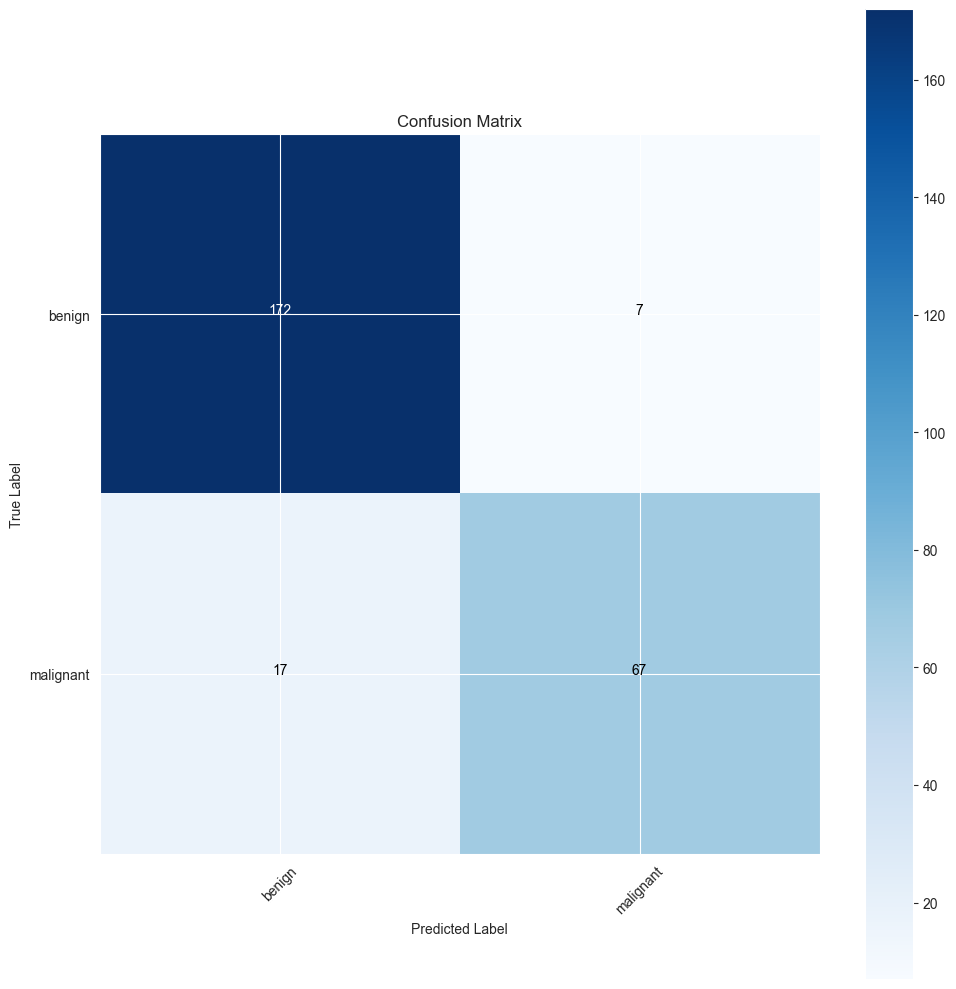

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      benign       0.91      0.96      0.93       179
   malignant       0.91      0.80      0.85        84

    accuracy                           0.91       263
   macro avg       0.91      0.88      0.89       263
weighted avg       0.91      0.91      0.91       263



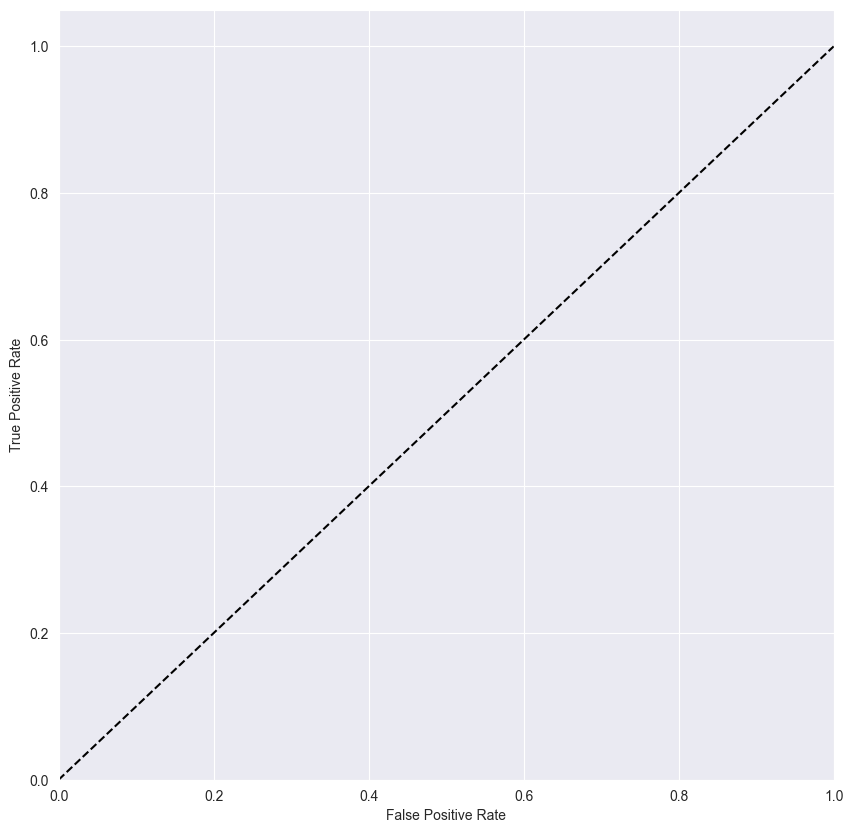

In [17]:
# roc curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
plt.figure(figsize= (10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()